# Enunciado

Etapa 1: Download e exploração dos dados
Acesse os dados públicos e faça uma análise exploratória
Link: https://analyse.kmi.open.ac.uk/open_dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

assessments = pd.read_csv('anonymisedData/assessments.csv')
courses = pd.read_csv('anonymisedData/courses.csv')
studentAssessment = pd.read_csv('anonymisedData/studentAssessment.csv')
studentInfo = pd.read_csv('anonymisedData/studentInfo.csv')
studentRegistration = pd.read_csv('anonymisedData/studentRegistration.csv')
studentVle = pd.read_csv('anonymisedData/studentVle.csv')
vle = pd.read_csv('anonymisedData/vle.csv')

## Datasets

Informações retiradas do site e uma análise de cada conjunto de dados

### Courses

File contains the list of all available modules and their presentations. The columns are:

- **code_module:** code name of the module, which serves as the identifier.
- **code_presentation:** code name of the presentation. It consists of the year and “B” for the presentation starting in February and “J” for the presentation starting in October.
- **length:** length of the module-presentation in days.

**The structure of B and J presentations may differ and therefore it is good practice to analyse the B and J presentations separately.** Nevertheless, for some presentations the corresponding previous B/J presentation do not exist and therefore the J presentation must be used to inform the B presentation or vice versa. In the dataset this is the case of CCC, EEE and GGG modules.

#### Resumo

- Cada curso tem seu código ```code_module```, que é identificador único e uma apresentação ```code_presentation```. A combinação dos dois torna uma entrada única.
- Apresentações B costumam ser diferentes das J. É bom analisar os tipos separadamente.
- Podem existir dados faltantes. Nesse caso, é recomendável considerar os dados da apresentação anterior, mesmo que ela seja de um tipo diferente. (Módulos CCC, EEE e GGG têm esse problema)

In [2]:
courses.groupby(['code_module', 'code_presentation']).agg({'code_presentation':'count'})

code_presentation
code_module code_presentation                   
AAA         2013J                              1
            2014J                              1
BBB         2013B                              1
            2013J                              1
            2014B                              1
            2014J                              1
CCC         2014B                              1
            2014J                              1
DDD         2013B                              1
            2013J                              1
            2014B                              1
            2014J                              1
EEE         2013J                              1
            2014B                              1
            2014J                              1
FFF         2013B                              1
            2013J                              1
            2014B                              1
            2014J                              1
GGG         2013J                              1
            2014B                              1
            2014J                              1

Todas as apresentações estão presentes, o que indica que o problema nos módulos CCC, EEE e GGG está em outro arquivo. Como é uma boa prática analizar apresentações B e J separadamente, vou criar novas colunas para ano e apresentação.

In [3]:
courses['presentation_year'] = courses['code_presentation'].str.slice(stop=-1)
courses['presentation_month'] = courses['code_presentation'].str.slice(start=-1)
courses.columns

Index(['code_module', 'code_presentation', 'module_presentation_length',
       'presentation_year', 'presentation_month'],
      dtype='object')

Essa tabela também contém informação da duração de cada uma das apresentações. Vou explorar como esses valores se comportam.

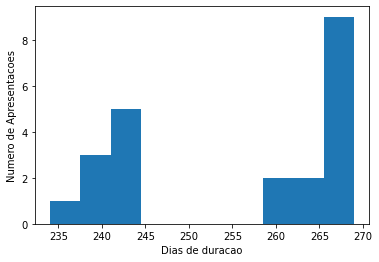

count     22.000000
mean     255.545455
std       13.654677
min      234.000000
25%      241.000000
50%      261.500000
75%      268.000000
max      269.000000
Name: module_presentation_length, dtype: float64

In [4]:
plt.hist(courses['module_presentation_length'])
plt.ylabel('Numero de Apresentacoes')
plt.xlabel('Dias de duracao')
plt.show()
courses['module_presentation_length'].describe()

Temos dois agrupamentos de dias. Isso pode estar relacionado ao ano ou ao periodo em que cada apresentação acontece. Podemos verificar essa relação usando um scatter plot. Como os números em cada grupo parecem somar para valores semelhantes, primeiro vou analisar a relação que o mês de início tem na duração.

Text(0.5, 0, 'Dias de duracao')

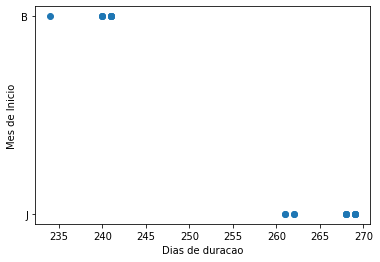

In [5]:
plt.scatter(courses['module_presentation_length'], courses['presentation_month'])
plt.ylabel('Mes de Inicio')
plt.xlabel('Dias de duracao')

Como podemos ver, o mês de início mostra uma separação clara entre apresentações que duram até ~245 dias e as que duram a partir de ~260 dias.


### Assessments

This file contains information about assessments in module-presentations. Usually, every presentation has a number of assessments followed by the final exam. CSV contains columns:

- **code_module:** identification code of the module, to which the assessment belongs.
- **code_presentation:** identification code of the presentation, to which the assessment belongs.
- **id_assessment:** identification number of the assessment.
- **assessment_type:** type of assessment. Three types of assessments exist: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam).
- **date:** information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).
- **weight:** weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.
If the information about the final exam date is missing, it is at the end of the last presentation week.

#### Resumo

- A junção de ```code_module``` e ```code_presentation``` determina um curso único e deve também existir no arquivo courses.
- Não devem existir dois ou mais ```id_assessment``` únicos.
- Somente 3 tipos de avaliação: ```TMA``` (avaliada por monitor), ```CMA``` (avaliada por computador) e ```Exam``` (prova final)
- A data das avaliações é contada em dias a partir do início do curso.
- Soma dos pesos é 100% para todos os tipos de avaliação menos provas.



In [6]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [7]:
len(assessments['id_assessment'].unique())

206

Primeiro, vou verificar se todos os cursos/apresentações listados aqui estão presentes também na base de dados de cursos.

In [8]:
assessment_modules = set(list(zip(assessments['code_module'], assessments['code_presentation'])))
courses_modules = set(list(zip(courses['code_module'], courses['code_presentation'])))

assessment_modules - courses_modules

set()

O conjunto vazio indica que todos os pares (curso, oferta) dessa tabela estão presentes também na tabela de cursos. Em seguida, vou conferir se não existem ```id_assessment``` utilizados mais de uma vez

In [9]:
np.unique(assessments['id_assessment'].value_counts().values)

array([1])

Também checando se existe algum erro de digitação ou tipo de avaliação desconhecido.

In [10]:
assessments['assessment_type'].value_counts()

TMA     106
CMA      76
Exam     24
Name: assessment_type, dtype: int64

Esse arquivo contém dados descritivos sobre avaliações nas várias apresentações de cada curso. Aqui não estão contidas as notas de cada aluno, mas sim, o tipo de avaliação, a data em que foi aplicada, e o peso da nota.

Nesse conjunto de dados existem várias coisas que podem estar erradas:

- Como já sabemos pela descrição do próprio site, existem problemas em 3 cursos e vou checar se é o caso nesse arquivo.
- É de se esperar que os pesos de todas avaliações menos provas somem 100% do peso em uma apresentação de um curso. Isso pode gerar outras questões:
    - Se o peso de uma prova for considerado. Torno o peso da prova 100 e refaço a escala das demais avaliações.
    - Se os pesos dos trabalhos não somar 100%, posso usar informações de outras ofertas do mesmo curso.
- Menos provável de acontecer, porém ainda relevante para a predição de resultados, vou conferir se todas as avaliações aconteceram dentro do prazo de duração informado no arquivo ```courses```.

Para checar se existe problema nos cursos mencionados anteriormente, vou conferir a soma dos pesos e as datas das avaliações. Primeiro, vou ver a soma dos pesos das atividades que não são provas:

In [11]:
assessments.loc[assessments['assessment_type'].isin(['TMA', 'CMA'])].groupby(['code_module', 'code_presentation']).agg({'weight':'sum'})

weight
code_module code_presentation        
AAA         2013J               100.0
            2014J               100.0
BBB         2013B               100.0
            2013J               100.0
            2014B               100.0
            2014J               100.0
CCC         2014B               100.0
            2014J               100.0
DDD         2013B               100.0
            2013J               100.0
            2014B               100.0
            2014J               100.0
EEE         2013J               100.0
            2014B               100.0
            2014J               100.0
FFF         2013B               100.0
            2013J               100.0
            2014B               100.0
            2014J               100.0
GGG         2013J                 0.0
            2014B                 0.0
            2014J                 0.0

Todos os cursos têm 100% de peso, exceto os cursos GGG, o que pode ser uma política do próprio curso. Vamos isolar essas apresentações.

In [12]:
assessments.loc[assessments['code_module'] == 'GGG']

,code_module,code_presentation,id_assessment,assessment_type,date,weight
176,GGG,2013J,37418,CMA,229.0,0.0
177,GGG,2013J,37419,CMA,229.0,0.0
178,GGG,2013J,37420,CMA,229.0,0.0
179,GGG,2013J,37421,CMA,229.0,0.0
180,GGG,2013J,37422,CMA,229.0,0.0
181,GGG,2013J,37423,CMA,229.0,0.0
182,GGG,2013J,37415,TMA,61.0,0.0
183,GGG,2013J,37416,TMA,124.0,0.0
184,GGG,2013J,37417,TMA,173.0,0.0
185,GGG,2013J,37424,Exam,229.0,100.0


Parece que de fato é uma poítica do curso. Temos várias atividades corrigidas por computador (6) vencendo no mesmo dia da prova final e atividades de monitores (3) ao longo do curso. Podem se tratar de atividades corriqueiras, porém sem peso na nota final. Não vou interferir nesses pesos no momento.

Uma outra pergunta que surge sobre a política de avaliação é: existe algum curso que aplica mais de uma prova?

In [13]:
assessments.loc[assessments['assessment_type'] == 'Exam'].groupby(['code_module', 'code_presentation']).agg({'assessment_type':'count'})

assessment_type
code_module code_presentation                 
AAA         2013J                            1
            2014J                            1
BBB         2013B                            1
            2013J                            1
            2014B                            1
            2014J                            1
CCC         2014B                            2
            2014J                            2
DDD         2013B                            1
            2013J                            1
            2014B                            1
            2014J                            1
EEE         2013J                            1
            2014B                            1
            2014J                            1
FFF         2013B                            1
            2013J                            1
            2014B                            1
            2014J                            1
GGG         2013J                            1
            2014B                            1
            2014J                            1

Os cursos do tipo CCC têm duas provas finais, o que não parece ser usual. Vou investigar.

In [14]:
assessments.loc[assessments['code_module'] == 'CCC'].sort_values(by='id_assessment')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
58,CCC,2014B,24282,TMA,32.0,9.0
59,CCC,2014B,24283,TMA,102.0,22.0
60,CCC,2014B,24284,TMA,151.0,22.0
61,CCC,2014B,24285,TMA,200.0,22.0
54,CCC,2014B,24286,CMA,18.0,2.0
55,CCC,2014B,24287,CMA,67.0,7.0
56,CCC,2014B,24288,CMA,137.0,8.0
57,CCC,2014B,24289,CMA,207.0,8.0
62,CCC,2014B,24290,Exam,NaN,100.0
68,CCC,2014J,24291,TMA,32.0,9.0


A estrutura das avaliações no curso CCC parece estranha. A cada oferta desse curso, temos dois exames finais sem data definida (NaN), sendo que um deles segue uma numeração em sequência com as demais avaliações e o outro, um número de sequência completamente fora do normal.

O número de sequência anormal me leva a crer que cada oferta tem uma avaliação lançada a mais. Porém, não vou fazer nada a respeito ainda, pois ainda não investiguei o conjunto de dados com as notas dos alunos em cada avaliação. Pode ser que de fato todos os alunos tenham notas distintas nas duas avaliações de cada oferta e esse foi apenas um erro na hora de lançar os dados.

Entretanto, um novo problema surgiu, que é o das datas indefinidas. Vou investigar se existem mais casos de números inválidos.

In [15]:
assessments[assessments.isnull().any(axis=1)]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Todas as ocorrências de datas inválidas são em provas finais. Minha primeira reação seria atribuir a essas provas a data final de cada uma das ofertas, usando dados do arquivo ```courses```. Porém, lendo a descrição de ```studentAssessment```, vou esperar e investigar se essas avaliações têm datas de submissão e uso essa informação.

Agora, vou ter uma noção melhor do comportamento das atividades. Algumas perguntas que pretendo responder:

- Como é a distribuição do número de atividades extras (CMA e TMA) por oferta?
- Como é a distribuição dos pesos das atividades extras? E quando agrupamos por tipo?
- Como acontecem as atividades ao longo do curso?
- Diferentes ofertas de um mesmo curso têm as mesmas atividades?

Começo a responder pela última pergunta:

**Diferentes ofertas de um mesmo curso têm as mesmas atividades?**

Para serem consideradas iguais, duas ofertas devem ter o mesmo número de atividades de cada tipo, com os mesmos pesos. Primeiro, vou investigar o número de atividades.

In [16]:
assessments.groupby(['code_module','code_presentation', 'assessment_type']).agg({'assessment_type':'count'})

assessment_type
code_module code_presentation assessment_type                 
AAA         2013J             Exam                           1
                              TMA                            5
            2014J             Exam                           1
                              TMA                            5
BBB         2013B             CMA                            5
                              Exam                           1
                              TMA                            6
            2013J             CMA                            5
                              Exam                           1
                              TMA                            6
            2014B             CMA                            5
                              Exam                           1
                              TMA                            6
            2014J             Exam                           1
                              TMA                            5
CCC         2014B             CMA                            4
                              Exam                           2
                              TMA                            4
            2014J             CMA                            4
                              Exam                           2
                              TMA                            4
DDD         2013B             CMA                            7
                              Exam                           1
                              TMA                            6
            2013J             Exam                           1
                              TMA                            6
            2014B             Exam                           1
                              TMA                            6
            2014J             Exam                           1
                              TMA                            6
EEE         2013J             Exam                           1
                              TMA                            4
            2014B             Exam                           1
                              TMA                            4
            2014J             Exam                           1
                              TMA                            4
FFF         2013B             CMA                            7
                              Exam                           1
                              TMA                            5
            2013J             CMA                            7
                              Exam                           1
                              TMA                            5
            2014B             CMA                            7
                              Exam                           1
                              TMA                            5
            2014J             CMA                            7
                              Exam                           1
                              TMA                            5
GGG         2013J             CMA                            6
                              Exam                           1
                              TMA                            3
            2014B             CMA                            6
                              Exam                           1
                              TMA                            3
            2014J             CMA                            6
                              Exam                           1
                              TMA                            3

Vemos que nos cursos BBB e DDD houveram mudanças no número de atividades aplicadas. Entretanto, ainda podem haver diferenças na alocação de pesos. Para verificar isso, vou procurar quais cursos têm diferenças de alocação nas suas ofertas.

In [17]:
# Funcao que recebe a lista de avaliacoes e retorna os cursos que têm distribuições de peso diferente nas suas atividades
# Retorna uma lista com o nome dos cursos
def get_weight_changes(assessments):
    # Lista vazia que armazenará os cursos com mudanças nos pesos
    changed_courses = []

    # Percorre todos os módulos separando em um novo dataframe somente os dados daquele módulo
    for module in np.unique(assessments['code_module']):
            # Filtra o df assessment
            module_df = assessments.loc[assessments['code_module'] == module]

            # Lista para armazenar as tuplas contendo os pesos das atividades
            module_weights = []
            # Percorre cada oferta do módulo em questão
            for presentation in np.unique(module_df['code_presentation']):
                # Isola somente as linhas com atividades do módulo e oferta em questão
                presentation_df = module_df.loc[module_df['code_presentation'] == presentation]
                # Primeiro ordena as linhas pelo tipo de avaliação e depois pela data
                # Extrai a lista de pesos das avaliações
                # Por causa da ordenação, vamos comparar os pesos de atividades equivalentes
                presentation_weights = tuple(presentation_df.sort_values(['assessment_type', 'date']).weight)
                # Inclui na lista de pesos
                module_weights.append(presentation_weights)
            
            # Avalia o tamanho do conjunto de pesos
            # Como estamos lidando com um conjunto, desconsideramos duplicadas
            # Portanto, se um curso tem N ofertas, mas todas as ofertas têm a mesma configuração de pesos
            # O tamanho do conjunto será 1
            if len(set(module_weights)) > 1:

                # Se o tamanho for maior que 1, aquele curso tem mais de uma configuração de pesos
                changed_courses.append(module)

    # Retorna a lista de cursos com diferença nos pesos
    return changed_courses

In [18]:
get_weight_changes(assessments)

['BBB', 'DDD']

Novamente, só os cursos BBB e DDD têm configurações de peso diferente. Pode ser por causa das ocorrências com uma atividade a mais ou a menos que já identificamos anteriormente. Para ter certeza, vou filtrar o dataset para excluir as ofertas com número diferente de atividades e executar novamente.

In [19]:
bbb_index = list(assessments.loc[assessments['code_module'] == 'BBB'].loc[assessments['code_presentation'] == '2014J'].index)
ddd_index = list(assessments.loc[assessments['code_module'] == 'DDD'].loc[assessments['code_presentation'] == '2013B'].index)

In [20]:
assessments_ = assessments.drop(bbb_index+ddd_index)
get_weight_changes(assessments_)

['DDD']

Ainda assim, o curso DDD possui distribuição de pesos diferente. Vou verificar manualmente.

In [21]:
assessments.loc[assessments['code_module'] == 'DDD']

,code_module,code_presentation,id_assessment,assessment_type,date,weight
74,DDD,2013B,25341,CMA,23.0,2.0
75,DDD,2013B,25342,CMA,51.0,3.0
76,DDD,2013B,25343,CMA,79.0,3.0
77,DDD,2013B,25344,CMA,114.0,4.0
78,DDD,2013B,25345,CMA,149.0,4.0
79,DDD,2013B,25346,CMA,170.0,3.0
80,DDD,2013B,25347,CMA,206.0,6.0
81,DDD,2013B,25334,TMA,25.0,7.5
82,DDD,2013B,25335,TMA,53.0,10.0
83,DDD,2013B,25336,TMA,81.0,12.5


Ao que parece, a última oferta de DDD teve uma nova distribuição de pesos.

**Como é a distribuição do número de atividades extras (CMA e TMA) por oferta?**

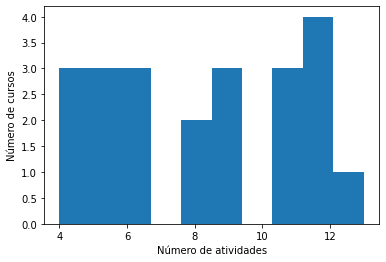

In [22]:
extra_counts = assessments.loc[assessments['assessment_type'] != 'Exam'].groupby(['code_module', 'code_presentation']).agg({'id_assessment':'count'})

plt.hist(extra_counts['id_assessment'])
plt.xlabel('Número de atividades')
plt.ylabel('Número de cursos')
plt.show()

In [23]:
extra_counts.id_assessment.describe()

count    22.000000
mean      8.272727
std       3.119552
min       4.000000
25%       5.250000
50%       8.500000
75%      11.000000
max      13.000000
Name: id_assessment, dtype: float64

Vemos que poucos cursos têm mais que 10 atividades extra, e em média cursos têm 8.27 atividades.

**Como é a distribuição dos pesos das atividades extras? E quando agrupamos por tipo?**

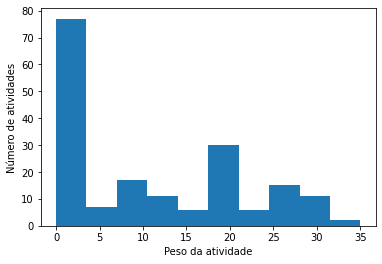

In [24]:
_ = assessments.loc[assessments['assessment_type'] != 'Exam']
plt.hist(_['weight'])
plt.xlabel('Peso da atividade')
plt.ylabel('Número de atividades')
plt.show()

Vemos que existe um grande número de atividades com peso 0, que correspondem às atividades do curso GGG, que dá peso 0 a tudo, menos à prova final. Além disso, temos um grande número de atividades com peso de 20% a 35%, e nenhuma atividade com peso entre 36% e 100%. O que indica que muitos cursos têm um grande número de atividades extras, concordando com o número médio de atividades que vimos anteriormente.

Agora, vou investigar a distribuição dos pesos quando agrupamos por tipo de atividade.

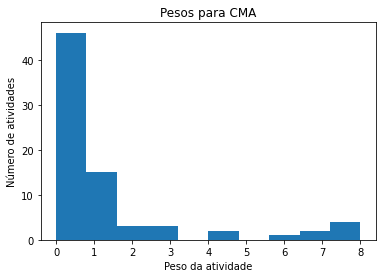

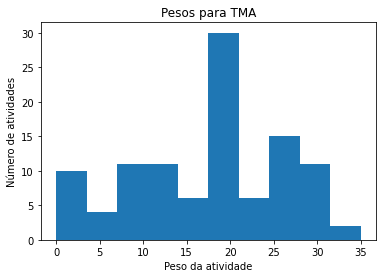

In [25]:
_ = assessments.loc[assessments['assessment_type'] != 'Exam'].loc[assessments['assessment_type'] == 'CMA']
plt.hist(_['weight'])
plt.xlabel('Peso da atividade')
plt.ylabel('Número de atividades')
plt.title('Pesos para CMA')
plt.show()
_ = assessments.loc[assessments['assessment_type'] != 'Exam'].loc[assessments['assessment_type'] == 'TMA']
plt.hist(_['weight'])
plt.xlabel('Peso da atividade')
plt.ylabel('Número de atividades')
plt.title('Pesos para TMA')
plt.show()

Vemos que atividades corrigidas por monitores (TMA) carregam mais peso. Assim, é possível interpretar CMAs como atividades menores, como trabalhos práticos, e TMAs como projetos de cursos, por exemplo.

**Como acontecem as atividades ao longo do curso?**

Veremos quais são as chances de existir uma atividade em cada um dos dias de um curso qualquer.

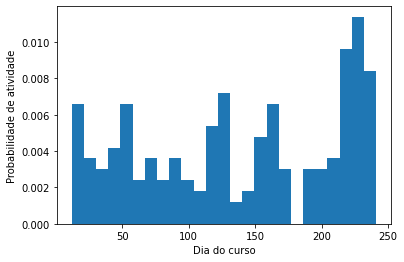

In [26]:
_ = assessments.dropna().loc[assessments['assessment_type'] != 'Exam']
plt.hist(_.date, bins = 25, density = True)
plt.ylabel('Probabilidade de atividade')
plt.xlabel('Dia do curso')
plt.show()

In [27]:
_.date.describe()

count    182.000000
mean     138.626374
std       74.633787
min       12.000000
25%       67.250000
50%      145.000000
75%      220.250000
max      241.000000
Name: date, dtype: float64

Vemos que existem picos ao longo do curso em que atividades são mais prováveis. Esses picos podem coincidir com o fim de módulos dentro de um curso, por exemplo. A atividade mais rápida dos cursos vence no dia 12, que pode corresponder a uma atividade de introdução ao conteúdo.

Além disso, chama a atenção um hiato por volta do dia 160~170 em que não existem atividades. Isso pode ser explicado como um período que os alunos têm para se preparar para as atividades finais do curso.

Esse gráfico poderia ser melhorado se normalizasse o dia de cada atividade usando a duração de cada oferta. Assim, deixaríamos de ter dias absolutos e passaríamos a ter porcentagem de conclusão de curso. Isso poderia inclusive mostrar características que independessem do mês de oferta.

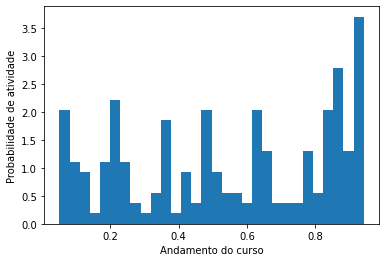

In [28]:
# Usei a função merge para realizar um join entre as duas tabelas.
# Mudei o índice das duas tabelas para as colunas que identificam unicamente cada entrada de curso
# Assim cada atividade ganha a informação da duração da oferta em que aconteceu
_ = assessments.set_index(['code_module','code_presentation']).merge(courses.set_index(['code_module','code_presentation']), left_index=True, right_index=True)
# Voltar com as colunas de índice para colunas normais
_ = _.reset_index()
# Filtrar linhas de provas finais
_ = _.loc[_['assessment_type'] != 'Exam']
# Criar a coluna de data relativa, que é a data em que uma atividade aconteceu, dividida pela duração do curso
_['relative_date'] = _['date']/_['module_presentation_length']

#Plotar o gráfico
plt.hist(_['relative_date'], bins = 30, density= True)
plt.ylabel('Probabilidade de atividade')
plt.xlabel('Andamento do curso')
plt.show()

Nessa nova versão, que leva em consideração o andamento relativo do curso, vemos que menos atividades vencem em 100% do curso, deixando essa data exclusivamente para provas. Além disso, vemos picos mais pronunciados.

### VLE

The csv file contains information about the available materials in the VLE. Typically these are html pages, pdf files, etc. Students have access to these materials online and their interactions with the materials are recorded. The vle.csv file contains the following columns:

- **id_site:** an identification number of the material.
- **code_module:** an identification code for module.
- **code_presentation:** the identification code of presentation.
- **activity_type:** the role associated with the module material.
- **week_from:** the week from which the material is planned to be used.
- **week_to:** week until which the material is planned to be used.

#### Resumo

- ```id_site``` identifica um material
- ```activity_type``` categoriza o tipo de material
- ```week_from``` e ```week_to``` indicam quando o material é recomendado, quando é o caso


In [29]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN



#### Perguntas

- Um material pode estar associado a mais de um curso?
- Ofertas de um mesmo curso mudam os materiais oferecidos?
- Quais os tipos de material mais comuns?
- Quando materiais são mais recomendados?

Começo respondendo a primeira pergunta: **Um material pode estar associado a mais de um curso?**

In [30]:
vle.groupby(['id_site', 'code_module']).agg({'code_module':'count'}).code_module.value_counts()

1    6364
Name: code_module, dtype: int64

In [31]:
np.unique(vle.id_site.value_counts().values)

array([1])

Vemos que só existe o valor 1 na contagem de módulos distintos associados aos ids de materiais. Assim, um material é único. Consequentemente, a resposta para a pergunta 2: **Ofertas de um mesmo curso mudam os materiais oferecidos?** é não.

Porém pode ser o caso de um mesmo material ser referenciado por dois ou mais ids. Portanto, vou investigar se o mix de tipos de material permanece o mesmo.

In [32]:
# Criando um novo dataframe com o agrupamento de informações
# Agrupo por ofertas de módulos únicos e pelo tipo de material
# Assim, tenho a contagem de cada tipo de material fornecido em cada uma das ofertas
material_mix = vle.groupby([ 'code_module','code_presentation', 'activity_type']).agg({'activity_type': 'count'})

# Função para descobrir os módulos que possuem o mesmo mix de materiais
# Recebe um dataframe com o agrupamento de módulos e ofertas mostrando a contagem de cada tipo de material
# Retorna a lista com os módulos
def get_same_mixes(material_mix):

    # Lista para armazenar os módulos com o mesmo mix de materiais
    modules_same = []

    # Iterar sobre cada módulo no dataframe de entrada
    for module in np.unique(material_mix.index.get_level_values('code_module')):
        # Separa em um dataframe somente as entradas de um mesmo módulo
        module_mix = material_mix.loc[material_mix.index.get_level_values('code_module') == module]
        # Retira o código do módulo do indes desse novo dataframe
        module_mix = module_mix.droplevel('code_module')

        # Lista para armazenar as contagens de mix de materiais
        mix_values = []
        for presentation in np.unique(module_mix.index.get_level_values('code_presentation')):
            # Separa o dataframe contendo só o mix de materiais de uma oferta do módulo em questão
            presentation_mix = module_mix.loc[module_mix.index.get_level_values('code_presentation') == presentation]

            # Não consigo fazer hash com dicionários, então vou usar uma tupla com os valores de cada tipo
            # Posso ter colisão de hash se um curso resolver trocar todos os seus forums por pdfs
            # E ainda assim manter a ordenação alfabética dos tipos
            # Isso é pouco provável
            mix_dict = presentation_mix.to_dict()
            mix_values.append(tuple(mix_dict['activity_type'].values()))
        
        # Se o conjunto de valores do mix de materiais tiver tamanho 1, aquele módulo tem o mesmo mix.
        if len(set(mix_values)) == 1:
            modules_same.append(module)

    # Retorna a lista de módulos escolhido
    return modules_same

get_same_mixes(material_mix)
        

[]

Desenvolvi a função ```get_same_mixes``` partindo do princípio que, por mais que um id de material não se repita, um mesmo pdf, por exemplo, pode ter sido cadastrado com dois ids diferentes em ofertas distintas. Por isso, ao invés de analisar se um material se repete, vou analisar o mix de materiais, que é a quantidade de cada tipo de material que uma oferta disponibiliza. Se dois mixes forem identicos, então assumo que duas ofertas tiveram o mesmo conjunto de materiais.

Infelizmente, esse não foi o caso, pois a lista retornada está vazia. O que me leva à próxima pergunta:

** Quais os tipos de materiais mais comuns?**

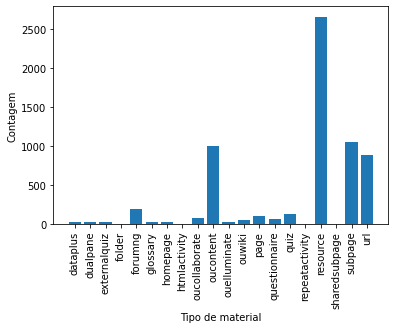

6364

In [33]:
_ = vle.groupby('activity_type').agg({'activity_type': 'count'}).to_dict()
_ = _['activity_type']
types = _.keys()
counts = _.values()
plt.bar(types, counts)
plt.xticks(rotation=90)
plt.xlabel('Tipo de material')
plt.ylabel('Contagem')
plt.show()
len(vle)

Vemos que dois dos recursos mais utilizados parecem nomes genéricos: oucontent e resource. Interpreto oucontent como conteúdo externo e resource como arquivo anexado. Além desses dois, temos subpáginas como um dos itens mais referenciados, que acredito se tratarem de páginas para outros conteúdos dentro do mesmo curso, e URLs como links para sites externos.

**Quando materiais são mais recomendados?**

(array([127.,  92.,  68., 139.,  89.,  77., 163., 122.,  87., 157.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

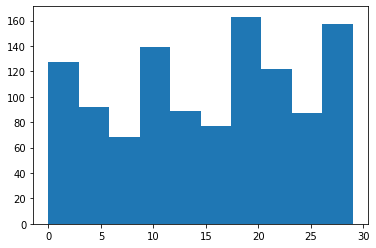

In [34]:
_ = vle.dropna()
plt.hist(_.week_from)

Essa medida de tempo é um pouco diferente da que estávamos lidando até então. Para chegar em dias contados, bastava multiplicar os dados de semana por 7. Entretanto, podemos ver os mesmos picos de atividades submetidas nas semanas em que materiais são recomendados.

### StudentInfo

This file contains demographic information about the students together with their results. File contains the following columns:

- **code_module:** an identification code for a module on which the student is registered.
- **code_presentation:** the identification code of the presentation during which the student is registered on the module.
- **id_student:** a unique identification number for the student.
- **gender:** the student’s gender.
- **region:** identifies the geographic region, where the student lived while taking the module-presentation.
- **highest_education:** highest student education level on entry to the module presentation.
- **imd_band:** specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation.
- **age_band:** band of the student’s age.
- **num_of_prev_attempts:** the number times the student has attempted this module.
- **studied_credits:** the total number of credits for the modules the student is currently studying.
- **disability:** indicates whether the student has declared a disability.
- **final_result:** student’s final result in the module-presentation.

In [35]:
studentInfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [36]:
studentInfo['id_student'].value_counts().values

array([5, 4, 4, ..., 1, 1, 1])

In [37]:
studentInfo['region'].unique()

array(['East Anglian Region', 'Scotland', 'North Western Region',
       'South East Region', 'West Midlands Region', 'Wales',
       'North Region', 'South Region', 'Ireland', 'South West Region',
       'East Midlands Region', 'Yorkshire Region', 'London Region'],
      dtype=object)

In [38]:
studentInfo['highest_education'].unique()

array(['HE Qualification', 'A Level or Equivalent', 'Lower Than A Level',
       'Post Graduate Qualification', 'No Formal quals'], dtype=object)

In [39]:
studentInfo['final_result'].unique()

array(['Pass', 'Withdrawn', 'Fail', 'Distinction'], dtype=object)

#### Resumo

Essa tabela contém dados de alunos nas diversas ofertas de cursos.

- Uma entrada única é definida por uma tripla (``ìd_student```, ```code_module```, ```code_presentation```)
- Os alunos parecem ser todos da Inglaterra e países vizinhos, as regiões parecem ser todas no Reino Unido.
- Por isso, temos a medida de IMD, que é um "índice de pobreza" usado nesses países.
- Os níveis de graduação também parecem ser os utilizados por lá, interpreto da seguinte maneira:
    - Post Graduate Qualification: Pós Graduação Completa
    - HE Qualification: Graduação/Bacharelado
    - A Level or Equivalent: Segundo Grau Completo ou Equivalente
    - Lower Than A Level: Segundo Grau Incompleto
    - No Formal quals: Nenhuma formação
- Temos informação sobre tentativas anteriores de um aluno em um mesmo módulo e o número de créditos concluídos. Não sabemos quantos créditos valem cada módulo, mas essa mesma tabela pode mostrar essa informação.
- Existem alunos com algum tipo de deficiência
- As notas são divididas em categorias:
    - Pass: Aprovado
    - Withdrawn: Abandonou
    - Fail: Reprovado
    - Distinction: Aprovado com mérito

#### Perguntas

Dados sobre pessoas levantam muitas perguntas interessantes:

- Quantos alunos estão presentes nos dados?
- Qual o número médio de módulos únicos cursados pelos alunos?
- Quantos alunos cada curso teve?
- Qual a proporção de homens e mulheres entre os alunos?
- De onde vem os alunos dos cursos?
    - Essa proporção se repete quando olhamos os alunos de um curso individualmente?
    - A proporção de homens e mulheres é a mesma nas regiões?
- Quão grande foi a mobilidade dos alunos ao longo da sua formação?
- Qual a faixa de IMD dos alunos?
    - Essa faixa tem relação com a região onde estão os alunos?
- Quão qualificados são os alunos?
    - Existem cursos mais procurados por alunos menos/mais qualificados?
- Qual o número médio de tentativas para um aluno ser aprovado em um curso?
- Qual a proporção de alunos com algum tipo de deficiência?

Começo pela primeira pergunta:

**Quantos alunos estão presentes nos dados?**
    

In [40]:
len(np.unique(studentInfo['id_student']))

28785

Temos 28785 alunos distribuidos nas ofertas de módulos vistas anteriormente.

**Qual o número médio de módulos cursados por alunos?**

In [41]:
studentInfo.groupby('id_student').agg({'code_module':'nunique'}).describe()

,code_module
count,28785.000000
mean,1.086816
std,0.284027
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


In [42]:
len(studentInfo)

32593

O número médio de módulos distintos é 1.086, o que indica que a grande maioria dos alunos cursa somente um módulo. Entretanto, o número máximo de módulos é 3, mas poucos alunos chegam a esse número.

Quando vemos o número de entradas na tabela e o número de alunos, temos cerca de 10.000 entradas a mais que o número de alunos. Como poucos alunos fazem mais de um módulo, atribuo esse número de entradas a mais a múltiplas tentativas. Investigaremos isso mais adiante.

**Quantos alunos cada curso teve?**

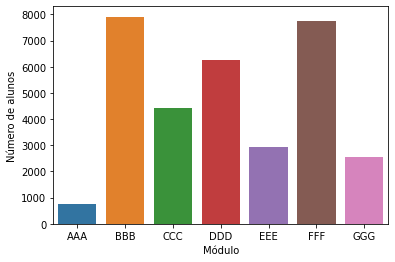

In [43]:
ax = sns.countplot(data=studentInfo, x='code_module')
ax.set_xlabel('Módulo')
ax.set_ylabel('Número de alunos')
plt.show()

O curso AAA é o menos popular, enquanto FFF e BBB são os mais populares.

**Qual a proporção de homens e mulheres entre os alunos?**

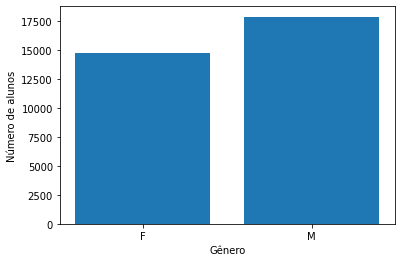

In [44]:
_ = studentInfo.groupby('gender').agg({'gender':'count'})['gender'].to_dict()
plt.bar(_.keys(), _.values())
plt.ylabel('Número de alunos')
plt.xlabel('Gênero')
plt.show()

In [45]:
studentInfo['gender'].value_counts(normalize=True)

M    0.548431
F    0.451569
Name: gender, dtype: float64

Temos mais homens que mulheres entre os alunos, mas a proporção não é tão distante: 55% homens e 45% mulheres.

**De onde vem os alunos dos cursos?**
- Essa proporção se repete quando olhamos os alunos de um curso individualmente?
- A proporção de homens e mulheres é a mesma nas regiões?**

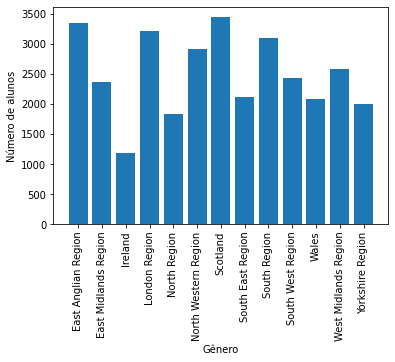

In [46]:
_ = studentInfo.groupby('region').agg({'region':'count'})['region'].to_dict()
plt.bar(_.keys(), _.values())
plt.ylabel('Número de alunos')
plt.xlabel('Gênero')
plt.xticks(rotation=90)
plt.show()

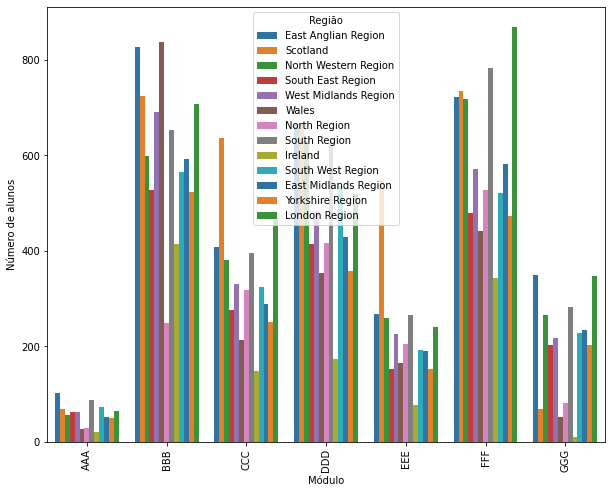

In [47]:
# Para esse gráfico optei por usar seaborn pois facilita o agrupamento
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(data=studentInfo, x = 'code_module', hue = 'region', palette='tab10')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Módulo')
ax.set_ylabel('Número de alunos')
ax.legend(title = 'Região', loc = 'best')
plt.show()

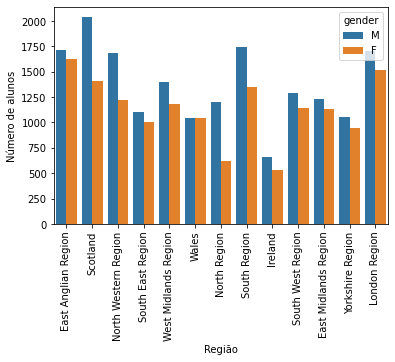

In [48]:
# Para esse gráfico optei por usar seaborn pois facilita o agrupamento
ax = sns.countplot(data=studentInfo, x = 'region', hue = 'gender')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Região')
ax.set_ylabel('Número de alunos')
plt.show()

Vemos alguns pontos interessantes nesses gráficos. Em geral, todas as regiões têm mais homens que mulheres matriculados, exceto em Wales, que tem um número semelhante. A Irlanda é a região com menos alunos e Escócia a com mais alunos.

O módulo AAA é o que tem menos alunos matriculados, e alguns módulos são extremamente populares entre alunos de algumas regiões. FFF faz sucesso em Londres, enquanto CCC e EEE tem a maioria dos seus alunos Escoceses.

**Quão grande foi a mobilidade dos alunos ao longo da sua formação?**



In [49]:
_ = studentInfo.groupby(['id_student']).agg({'region':'count'})
_['region'].value_counts(normalize=True)

1    0.877089
2    0.114400
3    0.007678
4    0.000799
5    0.000035
Name: region, dtype: float64

A maioria dos alunos permaneceu na mesma região ao longo de todos os módulos. 12% dos alunos moraram em mais de 1 região.

**Qual a faixa de IMD dos alunos?**
- **Essa faixa tem relação com a região onde estão os alunos?**


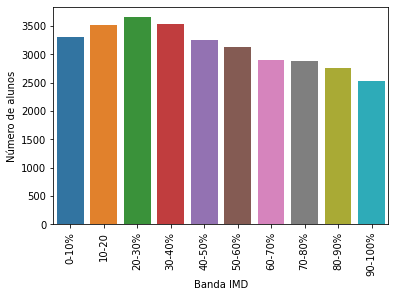

In [50]:
ax = sns.countplot(data=studentInfo, x='imd_band', order = sorted(studentInfo['imd_band'].dropna().unique()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Banda IMD')
ax.set_ylabel('Número de alunos')
plt.show()

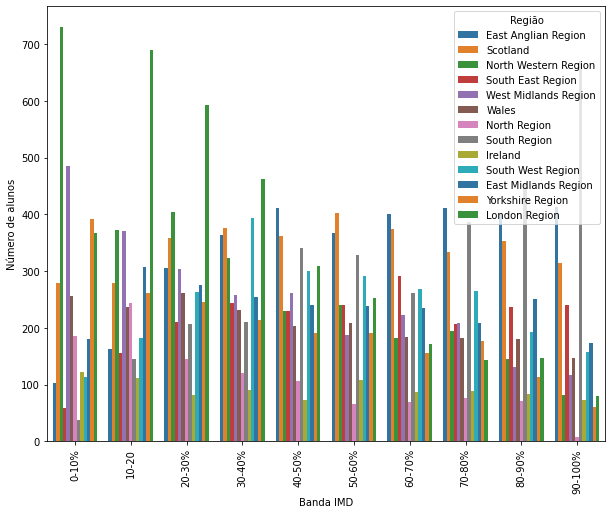

In [51]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(data=studentInfo, x='imd_band', order = sorted(studentInfo['imd_band'].dropna().unique()), hue = 'region', palette='tab10')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Banda IMD')
ax.set_ylabel('Número de alunos')
ax.legend(title = 'Região', loc = 'best')
plt.show()

Vemos que mais alunos tem índice IMD menor. Esse índice é uma medida de pobreza de regiões, portanto, temos mais alunos nas regiões mais ricas. Além disso, vemos como o índice IMD está distribuído nas regiões, mostrando que a região noroeste e Londres estão entre as mais ricas, enquanto East Anglian e Sul estão entre as mais pobres.

**Quão qualificados são os alunos?**
- **Existem cursos mais procurados por alunos menos/mais qualificados?**

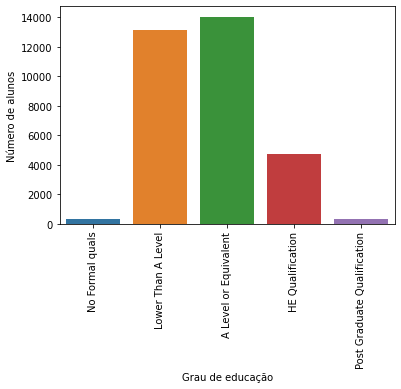

In [52]:
qual_order = ['No Formal quals', 'Lower Than A Level', 'A Level or Equivalent', 'HE Qualification', 'Post Graduate Qualification']
ax = sns.countplot(data=studentInfo, x = 'highest_education', order=qual_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Grau de educação')
ax.set_ylabel('Número de alunos')
plt.show()

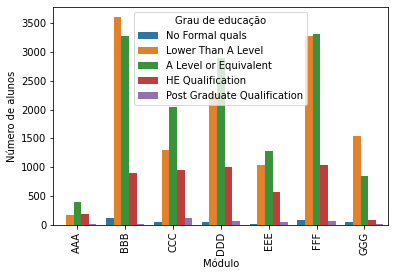

In [53]:
ax = sns.countplot(data=studentInfo, x = 'code_module', hue = 'highest_education', hue_order=qual_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Módulo')
ax.set_ylabel('Número de alunos')
ax.legend(title = 'Grau de educação', loc = 'best')
plt.show()

Vemos que a maioria dos alunos tem a formação básica, que é segundo grau completo ou incompleto. Uma pequena parcela tem a educação superior, e um número mínimo tem nenhum tipo de qualificação ou pós graduação completa.

Levando essas proporções para os módulos, vemos que alunos sem nenhuma qualificação não procuram o módulo AAA mas preferem os módulos BBB e FFF, enquanto grande parte dos pós graduados procuram CCC e FFF. Alunos com segundo grau incompleto são a maioria em GGG e BBB, invertendo a proporção geral dos dados.

**Qual o número médio de tentativas para um aluno ser aprovado em um curso?**


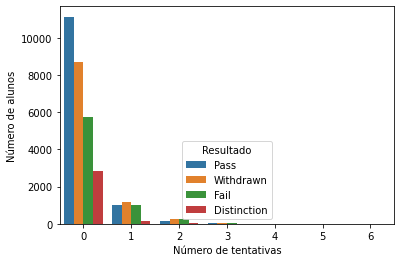

In [54]:
ax = sns.countplot(data = studentInfo, x = 'num_of_prev_attempts', hue = 'final_result')
ax.set_xlabel('Número de tentativas')
ax.set_ylabel('Número de alunos')
ax.legend(title = 'Resultado', loc = 'best')
plt.show()

In [55]:
studentInfo['num_of_prev_attempts'].value_counts(normalize = True)

0    0.871997
1    0.101218
2    0.020710
3    0.004357
4    0.001197
5    0.000399
6    0.000123
Name: num_of_prev_attempts, dtype: float64

A grande maioria das matrículas é a primeira vez do aluno e apenas 13% dos alunos tenta mais de uma vez. Interessante notar que a partir da segunda tentativa, o resultado mais comum não é que o aluno passe, e sim que abandone ou reprove a tentativa.

**Qual a proporção de alunos com algum tipo de deficiência?**


In [56]:
studentInfo['disability'].value_counts(normalize=True)

N    0.902924
Y    0.097076
Name: disability, dtype: float64

9,7% dos alunos tem algum tipo de deficiência.

Uma pergunta extra:

**Quão difíceis são os cursos?**

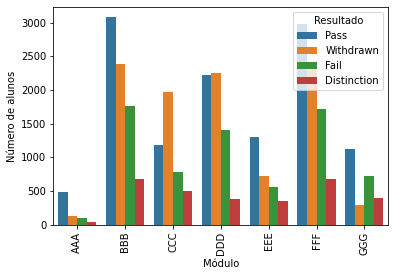

In [57]:
ax = sns.countplot(data=studentInfo, x = 'code_module', hue = 'final_result')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Módulo')
ax.set_ylabel('Número de alunos')
ax.legend(title = 'Resultado', loc = 'best')
plt.show()

CCC é um curso difícil, pois a maioria dos alunos desiste e a proporção de aprovados para reprovados é a menor.

### Student Registration

This file contains information about the time when the student registered for the module presentation. For students who unregistered the date of unregistration is also recorded. File contains five columns:

- **code_module:** an identification code for a module.
- **code_presentation:** the identification code of the presentation.
- **id_student:** a unique identification number for the student.
- **date_registration:** the date of student’s registration on the module presentation, this is the number of days measured relative to the start of the module-presentation (e.g. the negative value -30 means that the student registered to module presentation 30 days before it started).
- **date_unregistration:** date of student unregistration from the module presentation, this is the number of days measured relative to the start of the module-presentation. Students, who completed the course have this field empty. Students who unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file.

#### Resumo

Tabela que mostra quando alunos registraram nos cursos
- ```date_registration``` pode ser negativa quando aluno registra antes do curso começar. Espero que seja mais comum datas negativas, inclusive.
- ```date_unregistration``` só tem valor válido quando o aluno deu Withdraw no curso.


In [58]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN



#### Perguntas

- Quando os alunos mais se registram?
- Quando mais alunos desistem dos cursos?
- Alunos aprovados no curso se registram mais cedo?
- Quanto mais tarde o registro, maior a chance de reprovação? E de abandono?

**Quando os alunos mais se registram?**

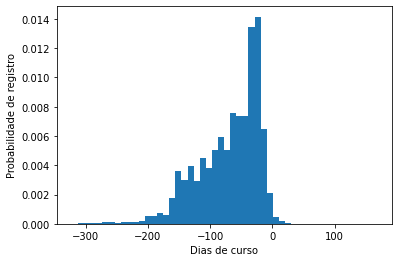

In [59]:
plt.hist(studentRegistration['date_registration'], bins = 50, density = True)
plt.xlabel('Dias de curso')
plt.ylabel('Probabilidade de registro')
plt.show()

In [60]:
studentRegistration['date_registration'].describe()

count    32548.000000
mean       -69.411300
std         49.260522
min       -322.000000
25%       -100.000000
50%        -57.000000
75%        -29.000000
max        167.000000
Name: date_registration, dtype: float64

Normalmente, alunos se registram antes do começo do curso. O pico de registro começa nos 50 dias que antecedem o começo, mas alguns alunos chegam a se registrar depois. O mais tarde que alguem se registrou foi no dia 167.

**Quando mais alunos desistem dos cursos?**

Text(0, 0.5, 'Probabilidade de registro')

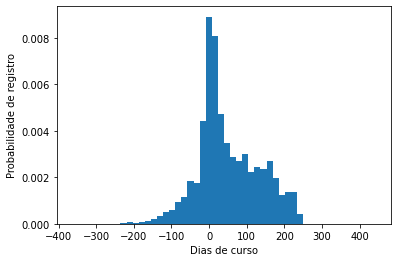

In [61]:
plt.hist(studentRegistration['date_unregistration'].dropna(), bins = 50, density = True)
plt.xlabel('Dias de curso')
plt.ylabel('Probabilidade de registro')

In [62]:
studentRegistration['date_unregistration'].describe()

count    10072.000000
mean        49.757645
std         82.460890
min       -365.000000
25%         -2.000000
50%         27.000000
75%        109.000000
max        444.000000
Name: date_unregistration, dtype: float64

Cerca de 1/4 dos alunos desiste do curso antes mesmo dele começar, o que é algo interessante, pois então 1/4 dos registros de alunos em cursos são de casos em que uma pessoa sequer assistiu uma aula. O pico das desistências se dá nos primeiros 50 dias. 

**Alunos aprovados no curso se registram mais cedo?**

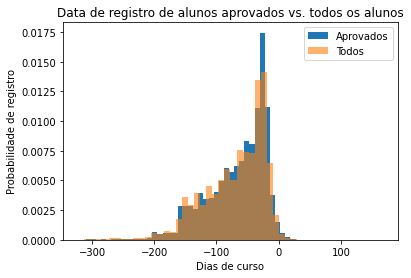

count    12360.000000
mean       -66.707848
std         47.374266
min       -310.000000
25%        -95.000000
50%        -53.000000
75%        -29.000000
max        101.000000
Name: date_registration, dtype: float64

In [63]:
# Join de studentInfo com studentRegistration para trazer dados de aprovacao para as datas de registro
studentRegistrationInfo = studentInfo.set_index(['code_module','code_presentation', 'id_student']).merge(studentRegistration.set_index(['code_module','code_presentation', 'id_student']), left_index=True, right_index=True)
# Voltar com as colunas de índice para colunas normais
studentRegistrationInfo = studentRegistrationInfo.reset_index()

plt.hist(studentRegistrationInfo.loc[studentRegistrationInfo['final_result'] == 'Pass']['date_registration'], bins = 50, density= True, label = 'Aprovados')
plt.hist(studentRegistration['date_registration'], bins = 50, density = True, alpha = 0.6, label = 'Todos')



plt.xlabel('Dias de curso')
plt.ylabel('Probabilidade de registro')
plt.title('Data de registro de alunos aprovados vs. todos os alunos')
plt.legend()
plt.show()

studentRegistrationInfo.loc[studentRegistrationInfo['final_result'] == 'Pass']['date_registration'].describe()

In [64]:
studentRegistrationInfo

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0


Apesar de diferentes, a distribuição das datas de registro de alunos aprovados não difere muito da distribuição de todos os alunos.

**Quanto mais tarde o registro, maior a chance de reprovação? E de abandono?**

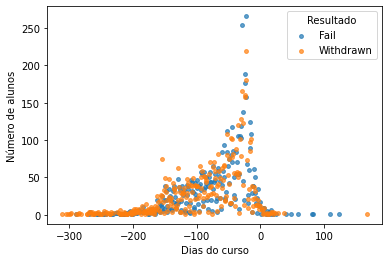

In [65]:
_ = studentRegistrationInfo.loc[studentRegistrationInfo['final_result'] == 'Fail'].groupby('date_registration').agg({'final_result': 'count'})

plt.scatter(_.index, _.final_result, color = 'C0', s = 15, alpha = 0.7, label = 'Fail')

_ = studentRegistrationInfo.loc[studentRegistrationInfo['final_result'] == 'Withdrawn'].loc[studentRegistrationInfo['date_unregistration'] > 0].groupby('date_registration').agg({'final_result': 'count'})

plt.scatter(_.index, _.final_result, color = 'C1', s = 15, alpha = 0.7, label = 'Withdrawn')

plt.ylabel('Número de alunos')
plt.xlabel('Dias do curso')
plt.legend(title = 'Resultado')
plt.show()

Escolhi estudar o número de alunos que desistiram ou falharam nos módulos vs. o dia em que se registraram. Esperava ver um número maior de alunos com dias positivos, indicando que se registraram após o início das aulas. Entretanto, a anormalidade que notei foi o pico de alunos que se registraram por volta de 150 dias antes e desistiram do curso. 

### Student Assessment

This file contains the results of students’ assessments. If the student does not submit the assessment, no result is recorded. The final exam submissions is missing, if the result of the assessments is not stored in the system. This file contains the following columns:
- **id_assessment:** the identification number of the assessment.
- **id_student:** a unique identification number for the student.
- **date_submitted:** the date of student submission, measured as the number of days since the start of the module presentation.
- **is_banked:** a status flag indicating that the assessment result has been transferred from a previous presentation.
- **score:** the student’s score in this assessment. The range is from 0 to 100. The score lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100.

#### Resumo

Essa é a tabela que relaciona alunos com avaliações.

- É possível aproveitar avaliações de outras ofertas de cursos.

In [66]:
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


Temos 173 linhas com valores inválidos. Vou investigar quais são esses valores.

In [67]:
studentAssessment.loc[set(studentAssessment.index)-set(studentAssessment.dropna().index)]

,id_assessment,id_student,date_submitted,is_banked,score
104964,34860,544930,51,0,NaN
122892,34877,581307,175,0,NaN
20497,15000,476278,173,0,NaN
104977,34860,545791,80,0,NaN
159251,37415,610738,87,0,NaN
...,...,...,...,...,...
48629,24285,548764,205,0,NaN
166390,37427,631786,221,0,NaN
136696,34890,625075,220,0,NaN
90106,25363,687765,41,0,NaN


Os valores inválidos são na coluna de pontuação. Portanto, a nota dessas atividades possivelmente pode ser ignorada.

#### Perguntas

- Qual a nota média das atividades?
- Qual o número de submissões por atividade?
- A nota média cai à medida que o tempo passa?
- Como são as notas de alunos aprovados vs. dos reprovados?

**Qual a nota média das atividades?**

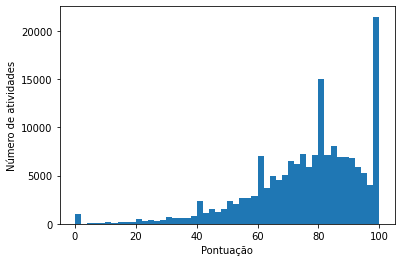

In [68]:
plt.hist(studentAssessment['score'], bins = 50)
plt.ylabel('Número de atividades')
plt.xlabel('Pontuação')
plt.show()

Temos muitos 100%, mas isso não é muito informativo do peso que esses 100% carregam. Vou incorporar dados de peso das atividades para ter uma melhor noção de como são as notas.

In [69]:
# Join de studentAssessment com assessments para trazer informação sobre peso e tipo de atividades.
studentAssessmentAssessment = assessments.set_index(['id_assessment']).merge(studentAssessment.set_index(['id_assessment']), left_index=True, right_index=True)
# Voltar com as colunas de índice para colunas normais
studentAssessmentAssessment = studentAssessmentAssessment.reset_index()

# Multipliquei weight por score para saber quantos "pontos" em média cada aluno fez por atividade
studentAssessmentAssessment['weighted_score'] = (studentAssessmentAssessment['weight']/100)*(studentAssessmentAssessment['score']/100)
studentAssessmentAssessment['weighted_score'] *= 100

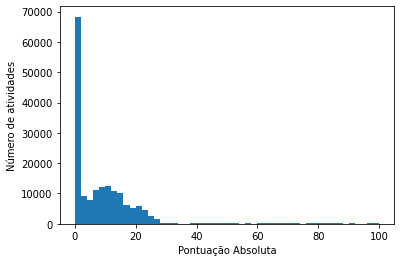

In [70]:
plt.hist(studentAssessmentAssessment['weighted_score'], bins = 50)
plt.ylabel('Número de atividades')
plt.xlabel('Pontuação Absoluta')
plt.show()

Vemos que ao levar peso em conta, a distribuição muda muito. Isso se dá por causa das muitas atividades que têm peso 0. Além disso, vemos que as atividades que não são provas contam para as pontuações abaixo de 40.

**Qual o número de submissões por atividade?**

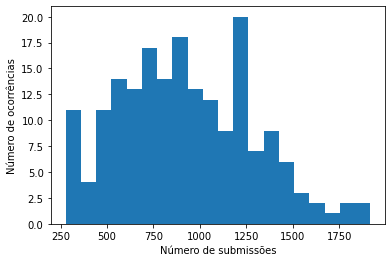

count     188.000000
mean      925.063830
std       360.001524
min       278.000000
25%       652.750000
50%       909.000000
75%      1192.250000
max      1917.000000
Name: id_assessment, dtype: float64

In [71]:
plt.hist(studentAssessment.groupby(['id_assessment']).agg({'id_assessment':'count'})['id_assessment'], bins = 20)
plt.ylabel('Número de ocorrências')
plt.xlabel('Número de submissões')
plt.show()

studentAssessment.groupby(['id_assessment']).agg({'id_assessment':'count'})['id_assessment'].describe()

Em média, atividades recebem 925 submissões. 

**A nota média cai à medida que o tempo passa?**

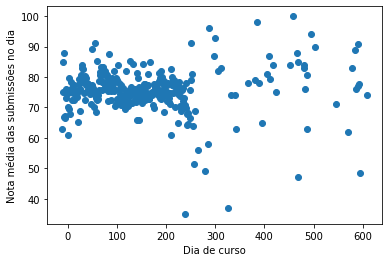

In [72]:
_ = studentAssessment.groupby(['date_submitted']).agg({'score':'mean'})
plt.scatter(_.index, _.values)
plt.ylabel('Nota média das submissões no dia')
plt.xlabel('Dia de curso')
plt.show()

Analisando as notas médias de cada dia de submissão vemos duas coisas: 1. existem submissões que extrapolam os dias máximos dos cursos (nenhum curso dura mais de 300 dias e temos submissões após o dia 600). 2. Por volta do dia 200, a média de notas parece cair. Vou dar um zoom no gráfico.

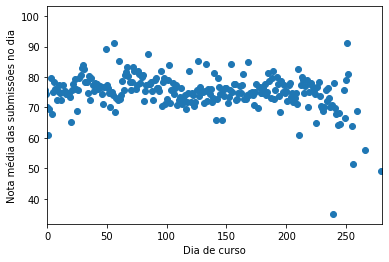

In [73]:
_ = studentAssessment.groupby(['date_submitted']).agg({'score':'mean'})
plt.scatter(_.index, _.values)
plt.xlim([0,280])
plt.ylabel('Nota média das submissões no dia')
plt.xlabel('Dia de curso')
plt.show()

De fato, existe uma tendência de queda nas médias de notas nos últimos dias de curso.

**Como são as notas de alunos aprovados vs. dos reprovados?**


In [74]:
# Join de studentAssessment com assessments para trazer informação sobre peso e tipo de atividades.
studentAssessmentInfo = studentInfo.set_index(['id_student']).merge(studentAssessment.set_index(['id_student']), left_index=True, right_index=True)
# Voltar com as colunas de índice para colunas normais
studentAssessmentInfo = studentAssessmentInfo.reset_index()

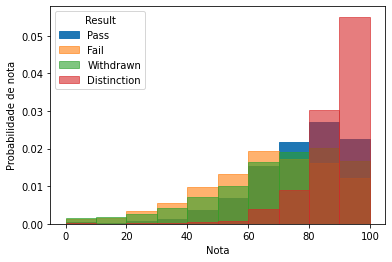

In [75]:
plt.hist(studentAssessmentInfo.loc[studentAssessmentInfo['final_result'] == 'Pass']['score'], density = True, label = 'Pass', edgecolor = 'C0', linewidth = 1)
plt.hist(studentAssessmentInfo.loc[studentAssessmentInfo['final_result'] == 'Fail']['score'], density = True, alpha = 0.6, label = 'Fail', edgecolor = 'C1', linewidth = 1)
plt.hist(studentAssessmentInfo.loc[studentAssessmentInfo['final_result'] == 'Withdrawn']['score'], density = True, alpha = 0.6, label = 'Withdrawn', edgecolor = 'C2', linewidth = 1)
plt.hist(studentAssessmentInfo.loc[studentAssessmentInfo['final_result'] == 'Distinction']['score'], density = True, alpha = 0.6, label = 'Distinction', edgecolor = 'C3', linewidth = 1, color = None)

plt.ylabel('Probabilidade de nota')
plt.xlabel('Nota')
plt.legend(title = 'Result')
plt.show()

Vemos alguns comportamentos interessantes na distribuição de notas dos alunos. Primeiramente, os alunos aprovados com distinção têm notas melhores que os remais. Em seguida, os aprovados têm maior proporção de notas maiores que 70 em relação aos reprovados, e menos notas menores que 60.

Ao analisar os alunos reprovados e desistentes, reparamos que os desistentes têm maior proporção de notas melhores que os reprovados. Isso pode indicar um dos motivos que leva um aluno a desistir de uma matéria, que é o mau desempenho em alguma atividade chave.

### Student VLE

The studentVle.csv file contains information about each student’s interactions with the materials in the VLE. This file contains the following columns:
- **code_module:** an identification code for a module.
- **code_presentation:** the identification code of the module presentation.
- **id_student:** a unique identification number for the student.
- **id_site:** an identification number for the VLE material.
- **date:** the date of student’s interaction with the material measured as the number of days since the start of the module-presentation.
- **sum_click:** the number of times a student interacts with the material in that day.

#### Resumo

Essa tabela relaciona alunos com materiais disponibilizados por curso. Podemos identificar a popularidade de materiais usando cliques diários.

É o maior conjunto de dados, portanto o processamento deve ser cuidadoso com memória e tempo.

In [76]:
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


#### Perguntas

- Qual o curso com mais acesso a materiais?
- Qual o material mais popular?
- Como são distribuídos os acessos ao longo dos dias?
- Como é distribuído o número de acessos por alunos?

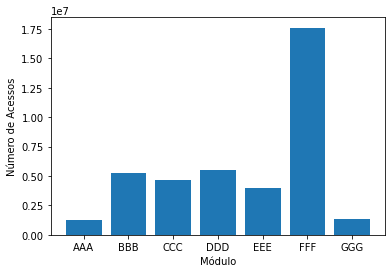

In [77]:
_ = studentVle.groupby('code_module')['sum_click'].sum().to_dict()
plt.bar(_.keys(), _.values())
plt.ylabel('Número de Acessos')
plt.xlabel('Módulo')
plt.show()

Vemos que o módulo FFF é o que mais possui acessos. Ele é também um dos cursos com maior número de alunos, entretanto, BBB tem número semelhante de alunos e menos acessos.

**Qual o material mais popular?**



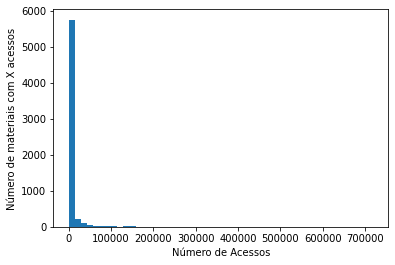

id_site
877206         1
798791         1
877143         1
768596         1
768494         1
           ...  
909013    442887
673519    455896
526721    586632
882537    716869
716238    718737
Name: sum_click, Length: 6268, dtype: int64

In [78]:
_ = studentVle.groupby('id_site')['sum_click'].sum().sort_values()
plt.hist(_, bins = 50)
plt.ylabel('Número de materiais com X acessos')
plt.xlabel('Número de Acessos')
plt.show()
_

Nessa distribuição temos dois extremos muito pronunciados. Muitos materiais com acesso único, e dois materiais que representam mais de 10% do número total de acessos. Por mais que exista alguma inconsistência nos registros de algum aluno, ainda assim é uma anormalidade, dado que o aluno que mais acessou um material específico, o fez 30000 vezes em um dia. e Poucos dias ultrapassaram 400000 acessos a todos os materiais.

**Como são distribuídos os acessos ao longo dos dias?**


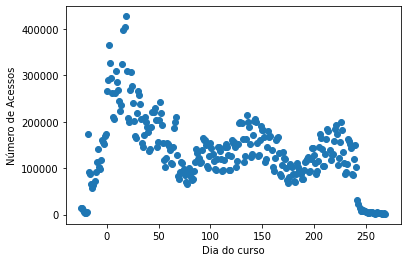

In [79]:
_ = studentVle.groupby('date')['sum_click'].sum()
plt.scatter(_.index, _.values)
plt.ylabel('Número de Acessos')
plt.xlabel('Dia do curso')
plt.show()

O número de acessos médios aos materiais mostra um comportamento típico de variáveis sazonais, como temperatura do ano e até mesmo congestionamentos em uma cidade. Nesse caso, a sazonalidade pode estar associada a sub-módulos dos cursos, que criam alta demanda por novos materiais.

**Como é distribuído o número de acessos por alunos?**

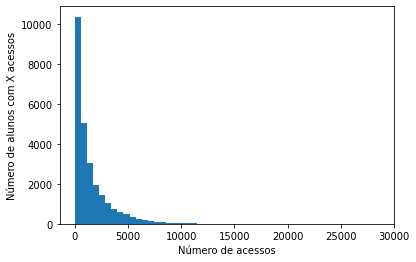

id_student
2610857        1
588485         1
594208         1
516447         1
571932         1
           ...  
434476     21204
619927     24368
537811     25159
630905     28264
80868      28615
Name: sum_click, Length: 26074, dtype: int64

In [80]:
_ = studentVle.groupby('id_student')['sum_click'].sum()
plt.hist(_, bins = 50)
plt.ylabel('Número de alunos com X acessos')
plt.xlabel('Número de acessos')
plt.show()

_.sort_values()

Essa distribuição de número de acesso a materiais por alunos se parece com uma distribuição de Pareto. Temos a maioria dos acessos atribuidos a uma pequena parcela de alunos e a maioria dos alunos com uma minoria de acessos. 

Vou investigar a correlação de acesso a materiais com o desempenho dos alunos

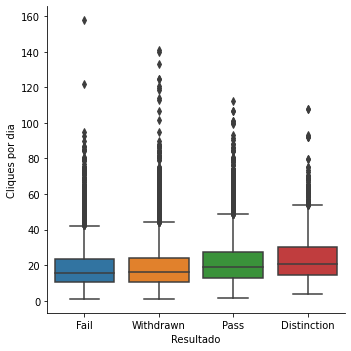

In [81]:
_ = studentVle.groupby('id_student').agg({'sum_click':'sum', 'date':'nunique'})
_ = _.reset_index()
_['clicks_day'] = _['sum_click']/_['date']
_ = _.merge(studentInfo, on='id_student')

ax = sns.catplot(x='final_result', y = 'clicks_day', data= _, kind='box', order= ['Fail', 'Withdrawn', 'Pass', 'Distinction'])
plt.xlabel('Resultado')
plt.ylabel('Cliques por dia')
plt.show()


Vemos que alunos aprovados nas matérias acessam mais materiais diariamente que os alunos reprovados ou que se retiraram do curso.

## Etapa 2: 

Defina qual pergunta você quer responder dentre as opções abaixo
- Quais são os diferentes perfis de estudantes? Quais características definem esses grupos
- **Como predizer o desempenho dos estudantes nas avaliações finais?**

## Etapa 3

Crie o modelo e avalie sua qualidade e precisão

Antes de partir para a predição do desempenho de alunos, é preciso primeiro definir o problema:

Dado o desempenho de um aluno até o momento da prova final, qual é a sua chance de ser aprovado?

Isso implica em definir como medir o desempenho do aluno até a prova final, e pretendo implementar novas features nos dados. Apesar de modelos de machine learning sofrerem com dados com muitas dimensões, vou criar novos atributos para que, caso sejam relevantes, técnicas de redução de dimensionalidade, possam se aproveitar deles. Primeiramente, vou reunir os dados de todas as tabelas que têm a ver com o desempenho de alunos:

- courses
    - Vou retirar a informação da duração de cada oferta para normalizar informações de data de submissão
- assessments
    - Peso, tipo e data de submissão de cada atividade
    - Filtrar somente as atividades que não são provas
- studentInfo 
    - Todas as colunas serão úteis
- studentRegistration
    - Vou usar a data de registro
- studentAssessment 
    - Data de submissão para calcular a data relativa de submissão em relação ao vencimento da atividade
    - Score para desempenho bruto e relativo ao peso da atividade
- vle e studentvle
    - Criar uma tabela resumida mostrando o número médio de acessos por dia a materiais de um mesmo tipo por aluno em uma oferta de módulo.


O modelo tomará como input um dataset com os dados de um aluno em uma oferta de um módulo e deverá prever se nesse módulo, o aluno será aprovado ou reprovado. Vou reduzir as escolhas unindo alunos aprovados e distintos em uma mesma categoria e alunos desistentes e reprovados em outra.

Vou criar uma nova tabela com o resumo das informações de VLE, que são as mais numerosas. Vou também recriar a métrica de acessos diários aos materiais.

In [82]:
# Juntando vle e studentVle para ter todas as informações de VLE
vleSummary = vle.merge(studentVle, on=['id_site', 'code_module', 'code_presentation'])

# Sobrescrevendo a variável para poupar memória. Vou guardar somente o agregado das informações agrupadas por aluno, curso, oferta, e tipo de conteúdo
vleSummary = vleSummary.groupby(['id_student', 'code_module', 'code_presentation']).agg({'sum_click':'sum', 'date':'nunique'})
# Voltando o índice do agrupamento para colunas normais para facilitar merges futuros
vleSummary = vleSummary.reset_index()

# Calculando a métrica de acessos médios por dia
vleSummary['clicks_day'] = vleSummary['sum_click']/vleSummary['date']
# Renomeando para evitar colisão no futuro
vleSummary.rename(columns={'date':'day_counts'}, inplace=True)

In [83]:
vleSummary

,id_student,code_module,code_presentation,sum_click,day_counts,clicks_day
0,6516,AAA,2014J,2791,159,17.553459
1,8462,DDD,2013J,646,56,11.535714
2,8462,DDD,2014J,10,1,10.000000
3,11391,AAA,2013J,934,40,23.350000
4,23629,BBB,2013B,161,16,10.062500
...,...,...,...,...,...,...
29223,2698257,AAA,2013J,758,69,10.985507
29224,2698535,CCC,2014B,786,34,23.117647
29225,2698535,EEE,2013J,3455,110,31.409091
29226,2698577,BBB,2014J,717,37,19.378378


Agora vou começar a construir a outra parte dessa tabela, que reúne informações sobre alunos, cursos e notas.


In [84]:
# Unindo courses e assessments
courseInfo = courses.merge(assessments, on=['code_module', 'code_presentation'])

# Filtrando somente as atividades que não são provas
courseInfo = courseInfo.loc[courseInfo['assessment_type'] != 'Exam']
# Calculando a data das atividades relativa ao início do curso
courseInfo['assessment_relative_date'] = courseInfo['date']/courseInfo['module_presentation_length']

# Unindo a tabela de alunos
studentCourseInfo = courseInfo.merge(studentInfo, on= ['code_module', 'code_presentation'])

# Unindo data de registro
studentCourseInfo = studentCourseInfo.merge(studentRegistration, on= ['code_module', 'code_presentation', 'id_student'])

# Unindo notas de atividades
studentCourseInfo = studentCourseInfo.merge(studentAssessment, on= ['id_assessment', 'id_student'])

# Calculando data relativa de submissão
studentCourseInfo['relative_date_submitted_assessment'] = studentCourseInfo['date_submitted']/studentCourseInfo['date']
studentCourseInfo['relative_date_submitted_course'] = studentCourseInfo['date_submitted']/studentCourseInfo['module_presentation_length']
# Calculando nota absoluta por atividade
studentCourseInfo['absolute_score'] = studentCourseInfo['score'] * studentCourseInfo['weight']
studentCourseInfo['absolute_score'] = studentCourseInfo['absolute_score']/100

studentCourseInfo

,code_module,code_presentation,module_presentation_length,presentation_year,presentation_month,id_assessment,assessment_type,date,weight,assessment_relative_date,...,disability,final_result,date_registration,date_unregistration,date_submitted,is_banked,score,relative_date_submitted_assessment,relative_date_submitted_course,absolute_score
0,AAA,2013J,268,2013,J,1752,TMA,19.0,10.0,0.070896,...,N,Pass,-159.0,NaN,18,0,78.0,0.947368,0.067164,7.8
1,AAA,2013J,268,2013,J,1753,TMA,54.0,20.0,0.201493,...,N,Pass,-159.0,NaN,53,0,85.0,0.981481,0.197761,17.0
2,AAA,2013J,268,2013,J,1754,TMA,117.0,20.0,0.436567,...,N,Pass,-159.0,NaN,115,0,80.0,0.982906,0.429104,16.0
3,AAA,2013J,268,2013,J,1755,TMA,166.0,20.0,0.619403,...,N,Pass,-159.0,NaN,164,0,85.0,0.987952,0.611940,17.0
4,AAA,2013J,268,2013,J,1756,TMA,215.0,30.0,0.802239,...,N,Pass,-159.0,NaN,212,0,82.0,0.986047,0.791045,24.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168948,GGG,2014B,241,2014,B,37432,CMA,222.0,0.0,0.921162,...,N,Distinction,-47.0,NaN,202,0,40.0,0.909910,0.838174,0.0
168949,GGG,2014B,241,2014,B,37433,CMA,222.0,0.0,0.921162,...,N,Distinction,-47.0,NaN,222,0,100.0,1.000000,0.921162,0.0
168950,GGG,2014B,241,2014,B,37425,TMA,61.0,0.0,0.253112,...,N,Distinction,-47.0,NaN,61,0,70.0,1.000000,0.253112,0.0
168951,GGG,2014B,241,2014,B,37426,TMA,117.0,0.0,0.485477,...,N,Distinction,-47.0,NaN,142,0,80.0,1.213675,0.589212,0.0


Unindo as duas partes, temos todos os dados que precisaremos, bastando agrupar por aluno, curso e oferta.

In [88]:
# Unindo os dois datasets
overallInfo = studentCourseInfo.merge(vleSummary, on= ['code_module', 'code_presentation', 'id_student'])

# Corrigindo erros de colunas
overallInfo['imd_band'].fillna('NA', inplace = True)

overallInfo.head()


,code_module,code_presentation,module_presentation_length,presentation_year,presentation_month,id_assessment,assessment_type,date,weight,assessment_relative_date,...,date_unregistration,date_submitted,is_banked,score,relative_date_submitted_assessment,relative_date_submitted_course,absolute_score,sum_click,day_counts,clicks_day
0,AAA,2013J,268,2013,J,1752,TMA,19.0,10.0,0.070896,...,NaN,18,0,78.0,0.947368,0.067164,7.8,934,40,23.35
1,AAA,2013J,268,2013,J,1753,TMA,54.0,20.0,0.201493,...,NaN,53,0,85.0,0.981481,0.197761,17.0,934,40,23.35
2,AAA,2013J,268,2013,J,1754,TMA,117.0,20.0,0.436567,...,NaN,115,0,80.0,0.982906,0.429104,16.0,934,40,23.35
3,AAA,2013J,268,2013,J,1755,TMA,166.0,20.0,0.619403,...,NaN,164,0,85.0,0.987952,0.611940,17.0,934,40,23.35
4,AAA,2013J,268,2013,J,1756,TMA,215.0,30.0,0.802239,...,NaN,212,0,82.0,0.986047,0.791045,24.6,934,40,23.35


In [89]:
# Definindo um encoder de categorias para variáveis mais simples. Para essas não vou utilizar one-hot
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Alterando os labels de final_result para que a classificação seja binária
overallInfo['result_binary'] = overallInfo['final_result']
overallInfo.loc[overallInfo['final_result'] == 'Distinction', 'result_binary'] = 'Pass'
overallInfo.loc[overallInfo['final_result'] == 'Withdrawn', 'result_binary'] = 'Fail'
overallInfo['result_binary'].unique()

# Vou armazenar uma lista para selecionar as colunas em que quero aplicar a codificação
labelColumns = ['code_module',
 'code_presentation',
 'presentation_month',
 'assessment_type',
 'gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability',
 'result_binary']


# Codificando cada coluna separadamente
for column in labelColumns:
    print('Transforming', column)
    overallInfo[column] = le.fit_transform(overallInfo[column])

# Declarar um dicionário com as agregações que desejo fazer em cada coluna
# Estou usando colunas numéricas e muitas delas têm valor constante
# Por isso, extraindo a média, consigo o valor daquele agrupamento
groupColumns = [
    'code_module',
    'code_presentation',
    'presentation_year',
    'presentation_month',
    'id_student'
    ]
aggregations = {
    'module_presentation_length': 'mean',
    'gender': 'mean',
    'region': 'mean',
    'highest_education': 'mean',
    'imd_band': 'mean',
    'age_band': 'mean',
    'num_of_prev_attempts': 'mean',
    'studied_credits': 'mean',
    'disability': 'mean',
    'result_binary': 'mean',
    'date_registration': 'mean',
    'date_submitted': 'mean',
    'score': 'mean',
    'relative_date_submitted_assessment': 'mean',
    'relative_date_submitted_course': 'mean',
    'absolute_score': 'mean',
    'clicks_day': 'mean'
}

# Criando um novo dataframe com o resultado do agrupamento
features = overallInfo.groupby(groupColumns).agg(aggregations)
features = features.reset_index()
features.dropna(inplace=True)
features.head()

Transforming code_module
Transforming code_presentation
Transforming presentation_month
Transforming assessment_type
Transforming gender
Transforming region
Transforming highest_education
Transforming imd_band
Transforming age_band
Transforming disability
Transforming result_binary


,code_module,code_presentation,presentation_year,presentation_month,id_student,module_presentation_length,gender,region,highest_education,imd_band,...,studied_credits,disability,result_binary,date_registration,date_submitted,score,relative_date_submitted_assessment,relative_date_submitted_course,absolute_score,clicks_day
0,0,1,2013,1,11391,268,1,0,1,9,...,240,0,1,-159.0,112.4,82.0,0.977151,0.419403,16.48,23.350000
1,0,1,2013,1,28400,268,0,6,1,2,...,60,0,1,-53.0,114.2,66.4,1.025809,0.426119,13.08,17.937500
2,0,1,2013,1,31604,268,0,7,0,5,...,60,0,1,-52.0,112.2,76.0,0.961352,0.418657,15.26,17.544715
3,0,1,2013,1,32885,268,0,11,2,5,...,60,0,1,-176.0,125.6,54.4,1.188012,0.468657,11.00,14.771429
4,0,1,2013,1,38053,268,1,10,0,8,...,60,0,1,-110.0,116.2,68.0,1.037037,0.433582,13.38,17.097902


In [91]:
features.columns

Index(['code_module', 'code_presentation', 'presentation_year',
       'presentation_month', 'id_student', 'module_presentation_length',
       'gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'result_binary', 'date_registration', 'date_submitted', 'score',
       'relative_date_submitted_assessment', 'relative_date_submitted_course',
       'absolute_score', 'clicks_day'],
      dtype='object')

Agora que tenho um dataset com o qual trabalhar, tenho algumas tarefas pela frente:

- Separar entradas e saídas em conjuntos X e Y para treinar modelos
- Dividir o dataset em conjunto de treino e teste para garantir que o modelo é eficaz e genérico o suficiente para lidar com novos dados. Vou usar uma divisão de 80/20 em cross validation, resultando em 5 iterações.
- Treinar 2 modelos em cada split:
    - Alimentado com dados originais, usando as N colunas mais correlacionadas
    - Alimentado com o resultado da transformação do PCA em N dimensões

A tarefa de prever se um aluno será ou não aprovado em um curso é uma tarefa de classificação, que vai atribuir uma categoria aprovado ou reprovado a um aluno dadas as suas características. Portanto, vou avaliar também 3 modelos de classificação:

- Árvore de decisão, que usa separações lineares em atributos dos dados para atribuir classes
- MLP, uma rede neural densa e profunda
- Random Forest, um conjunto de árvores de decisão

Para avaliar cada combinação de modelo e dado fornecido, vou utilizar 3 métricas:

- Accuracy: mede o número de classes acertadas no contexto geral, precisão simples.
- F1-score: mede a relação entre precisão e revocação. Precisão mede a proporção de verdadeiros positivos retornados pelo modelo, enquanto a revocação mede a abrangência de verdadeiros positivos dentre todos os resultados positivos.
- ROC AUC: mede a capacidade do modelo em distinguir corretamente as classes.

Todas as métricas têm valores entre 0 e 1, e o modelo perfeito tem 1 em todos os resultados.



In [103]:
# Definindo n
n = 7
#Escolhendo as N features mais correlacionadas ao resultado
correlations = features.corr()
feature_corr = correlations['result_binary'].sort_values(ascending = False)
# Excluir a primeira linha para ignorar o próprio resultado
feature_corr = feature_corr[1:]
Xcolumns = list(feature_corr.index[0:n])

#Colunas para rodar PCA = todas menos resultado
columnsPCA = list(features.columns)
columnsPCA.remove('result_binary')

#separando os conjuntos X
Xcorr = features[Xcolumns]
Xpca = features[columnsPCA]

#separando conjunto Y
Y = features['result_binary']


from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Configurando o PCA para N dimensoes
pca = PCA(n)

# Vou usar pipelines da biblioteca sklearn, que é uma maneira de alimentar modelos com os resultados de operações de transformação dos dados
# Lista de modelos para os dados brutos
pipelinesRaw = []

# O primeiro modelo tem um scaler, que coloca todos os dados no intervalo [0,1] e depois alimenta o classificador, que é uma árvore de decisão
pipelinesRaw.append(('Arvore de Decisao', Pipeline([('Scaler', StandardScaler()),('Model',DecisionTreeClassifier())])))
# O segundo modelo usa o mesmo scaler alimentando um Random Forest, um método que combina várias árvores de decisão
pipelinesRaw.append(('Random Forest', Pipeline([('Scaler', StandardScaler()),('Model',RandomForestClassifier())])))
# O segundo modelo também usa o scaler e alimenta uma MLP, uma rede neural densa
pipelinesRaw.append(('MLP', Pipeline([('Scaler', StandardScaler()),('Model',MLPClassifier())])))

# Para os dados que passam pelo PCA aplico a mesma lógica dos dados brutos, porém incluo o PCA com N dimensões
pipelinesPCA = []
pipelinesPCA.append(('Arvore de Decisao PCA', Pipeline([('Scaler', StandardScaler()),('PCA', pca),('Model',DecisionTreeClassifier())])))
pipelinesPCA.append(('Random Forest PCA', Pipeline([('Scaler', StandardScaler()),('PCA', pca),('Model',RandomForestClassifier())])))
pipelinesPCA.append(('MLP PCA', Pipeline([('Scaler', StandardScaler()),('PCA', pca),('Model',MLPClassifier())])))

# Definindo as métricas que serão usadas para avaliar e o nome que elas receberão nos resultados
scoring = {'acc': 'accuracy',
        'f1': 'f1',
        'roc': 'roc_auc'}

# Executa cada modelo na lista de pipelines
for name, model in pipelinesRaw:
    # Executa o modelo em 5 iterações de validação cruzada, usando os dados das N colunas mais correlacionadas à nota final. Em seguida, retorna diversas métricas de resultado, inclusive as definidas em scoring
    scores = cross_validate(model, Xcorr, Y, scoring=scoring,
                         cv=5, return_train_score=True)
    
    print(name)
    print('\t Accuracy: \t', np.mean(scores['test_acc']))
    print('\t F1: \t\t', np.mean(scores['test_f1']))
    print('\t ROC: \t\t', np.mean(scores['test_roc']))  

# Executa os modelos da lista de PCA
for name, model in pipelinesPCA:

    # Executa o modelo em 5 iterações de validação cruzada, usando os dados inteiros pois o PCA seleciona as N melhores features. Em seguida, retorna diversas métricas de resultado, inclusive as definidas em scoring
    scores = cross_validate(model, Xpca, Y, scoring=scoring,
                         cv=5, return_train_score=True)
    
    print(name)
    print('\t Accuracy: \t', np.mean(scores['test_acc']))
    print('\t F1: \t\t', np.mean(scores['test_f1']))
    print('\t ROC: \t\t', np.mean(scores['test_roc']))  

    #print(name, cv_results.mean(), cv_results.std())

Arvore de Decisao
	 Accuracy: 	 0.7760327307375671
	 F1: 		 0.7952855526059538
	 ROC: 		 0.7809834652355248
Random Forest
	 Accuracy: 	 0.8219110889995938
	 F1: 		 0.8361244632153015
	 ROC: 		 0.928859591330639
MLP
	 Accuracy: 	 0.8229970209719237
	 F1: 		 0.836032794448009
	 ROC: 		 0.9114742075629222
Arvore de Decisao PCA
	 Accuracy: 	 0.7340755942687911
	 F1: 		 0.7567976055703716
	 ROC: 		 0.7403363913797522
Random Forest PCA
	 Accuracy: 	 0.8067382429941915
	 F1: 		 0.8292817938622443
	 ROC: 		 0.8933712668168212
MLP PCA
	 Accuracy: 	 0.831893213625784
	 F1: 		 0.8547474947673713
	 ROC: 		 0.9117648495904561


Analisando as métricas dos modelos, notamos alguns fatos interessantes:

- O modelo de maior precisão foi a rede neural usando dados transformados pelo PCA. 
- As árvores de decisão e o modelo random forest não se beneficiaram dos dados transformados pelo PCA. Possivelmente, os atributos originais proporcionam uma separação melhor nesses modelos.
- Apesar de ser o modelo mais preciso, a rede neural usando PCA não é o modelo que distingue melhor as duas classes de alunos. O modelo random forest sem PCA teve, em média, uma melhor relação entre verdadeiros positivos e falsos negativos. Ou seja, foi mais sensível e específico que a rede neural. Por isso, a métrica ROC é a maior.

Entretanto, julgo que a métrica mais relevante quando lidamos com classificação é precisão. Portanto, o melhor modelo segundo esse critério é a rede MLP usando PCA para reduzir as dimensões do conjunto de dados.

---

Esses modelos foram todos utilizados em suas configurações padrão. Porém, é possível melhorar a qualidade dos resultados dedicando um tempo maior se otimizarmos os hiperparâmetros de cada modelo. Isso toma tempo, pois envolve testar diversas combinações de parâmetros com todo o conjunto de dados, porém, em aplicações mais sensíveis é o recomendado.

Além disso, como usei redes neurais, também é possível descrever arquiteturas específicas com tipos diferentes de camadas, como camadas de dropout (que minimizam o overfit) com bibliotecas como keras.

Etapa 4: Com base nas etapas anteriores, crie uma apresentação que responda às seguintes perguntas:

- Quais são as principais características da base de dados?
- Qual foi o problema de negócio escolhido?
- Qual foi o modelo utilizado e qual o motivo da escolha? Outros foram testados?
- Como você avalia os resultados obtidos?